In [1]:
import string
import numpy as np
import scipy as sc
import pandas as pd
import pickle
import csv
import random
import matplotlib.pyplot as plt
from sklearn import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.externals import *
from sklearn.utils import shuffle
from sklearn.naive_bayes import *
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from nltk import *
from textblob import TextBlob, Word
import subprocess
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

In [2]:
SUBSET_POS = 'train_pos.txt'
SUBSET_NEG = 'train_neg.txt'

DATA_POS = 'train_pos_full.txt'
DATA_NEG = 'train_neg_full.txt'

CLEAN_DATA_POS = 'train_pos_full_clean.txt'
CLEAN_DATA_NEG = 'train_neg_full_clean.txt'
CLEAN_TEST = 'test_data_clean.txt'

TEST_DATA = 'test_data.txt'

In [3]:
# Loading data
pos = pd.read_csv(DATA_POS, header=None, delimiter="\n", names=["tweets"])
neg = pd.read_csv(DATA_NEG, header=None, delimiter="\n", names=["tweets"])
test = pd.read_csv(TEST_DATA, header=None, delimiter="\n", names=["tweets"])
voc = pd.read_csv('vocab_cut.txt', header=None)

In [5]:
pos.head()

,0
0,<user> i dunno justin read my mention or not ....
1,"because your logic is so dumb , i won't even c..."
2,""" <user> just put casper in a box ! "" looved t..."
3,<user> <user> thanks sir > > don't trip lil ma...
4,visiting my brother tmr is the bestest birthda...


In [7]:
neg.head()

,0
0,vinco tresorpack 6 ( difficulty 10 of 10 objec...
1,glad i dot have taks tomorrow ! ! #thankful #s...
2,1-3 vs celtics in the regular season = were fu...
3,<user> i could actually kill that girl i'm so ...
4,<user> <user> <user> i find that very hard to ...


# Data Exploration

In [14]:
# Dimension of the data

# Positive
print("Positive tweets, number of tweets:", pos.shape[0])

# Negative
print("Negative tweets, number of tweets:", neg.shape[0])

# Test data
print("Test data tweets, number of tweets:", test.shape[0])

Positive tweets, number of tweets: 1216259
Negative tweets, number of tweets: 1238237
Test data tweets, number of tweets: 10000


In [15]:
# Mean of the number of words per tweet

# Positive
num_words = pos["tweets"].str.split().str.len()
print("Positive tweets, mean of the number of words per tweet:", np.mean(num_words))

# Negative
num_words = neg["tweets"].str.split().str.len()
print("Negative tweets, mean of the number of words per tweet:", np.mean(num_words))

# Test data
num_words = test["tweets"].str.split().str.len()
print("Test data tweets, mean of the number of words per tweet:", np.mean(num_words))

Positive tweets, mean of the number of words per tweet: 14.680184072635845
Negative tweets, mean of the number of words per tweet: 17.26942499699169
Test data tweets, mean of the number of words per tweet: 15.6988


In [13]:
# Median of the number of words per tweet

# Positive
num_words = pos["tweets"].str.split().str.len()
print("Positive tweets, median of the number of words per tweet:", np.median(num_words))

# Negative
num_words = neg["tweets"].str.split().str.len()
print("Negative tweets, median of the number of words per tweet:", np.median(num_words))

# Test data
num_words = test["tweets"].str.split().str.len()
print("Test data tweets, median of the number of words per tweet:", np.median(num_words))

Positive tweets, median of the number of words per tweet: 13.0
Negative tweets, median of the number of words per tweet: 18.0
Test data tweets, median of the number of words per tweet: 15.0


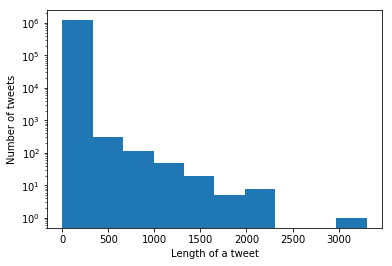

In [79]:
# Plot the distribution of the length of the tweets

lengths = pos["tweets"].apply(lambda x: len(x.split()))
plt.hist(lengths, log=True)
plt.xlabel('Length of a tweet')
plt.ylabel('Number of tweets')
plt.show()

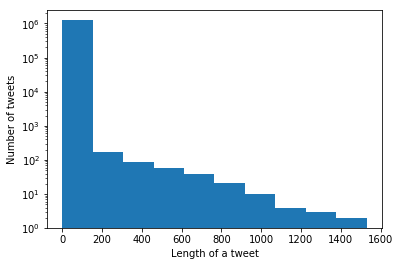

In [80]:
lengths = neg["tweets"].apply(lambda x: len(x.split()))
plt.hist(lengths, log=True)
plt.xlabel('Length of a tweet')
plt.ylabel('Number of tweets')
plt.show()

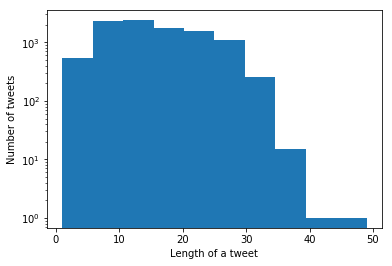

In [81]:
lengths = test["tweets"].apply(lambda x: len(x.split()))
plt.hist(lengths, log=True)
plt.xlabel('Length of a tweet')
plt.ylabel('Number of tweets')
plt.show()

In [33]:
# Plot sentiment distribution

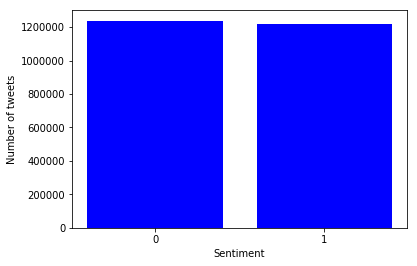

In [82]:
from collections import Counter

labels = [1] * pos.shape[0] + [0] * neg.shape[0]
count_map = Counter(labels)
counts = [count_map[i] for i in range(2)]
plt.bar(np.arange(2), counts, width=0.8, color='b')
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.xticks(np.arange(2), np.arange(2))
plt.show()

In [83]:
# Plot frequency distribution of words

In [84]:
def plot_freq_word(df):

    all_words = []
    for t in df.tweets.values:
        for w in t.split():
            if len(w) > 2:
                all_words.append(w)

    all_words_df = pd.Series(all_words)
    words_count = pd.DataFrame(all_words_df.groupby(all_words_df.values).count().sort_values(ascending=False)).reset_index()
    words_count.columns = ["word", "count"]
    words_count.head(20).plot.bar(x="word", y="count")

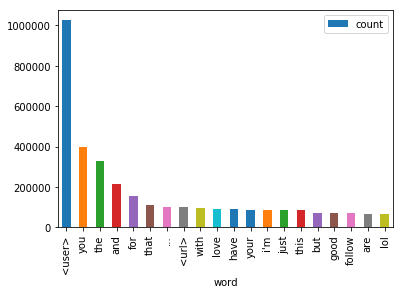

In [86]:
# Positive tweets
plot_freq_word(pos)

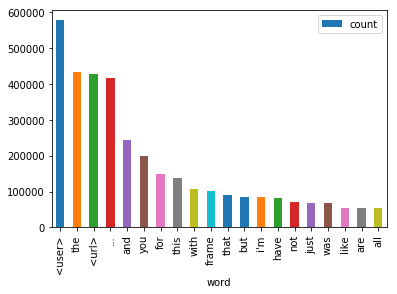

In [85]:
# Negative tweets
plot_freq_word(neg)

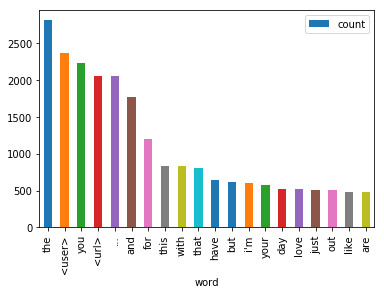

In [87]:
# Test tweets
plot_freq_word(test)

# Data preprocessing and cleaning

In [4]:
def clean_data(file, drop_dup = True):
    
    data = pd.read_csv(file, header=None, delimiter="\n", names=["tweet"])
    
    if drop_dup:
        # Removing duplicates
        data.drop_duplicates(inplace=True)
    
    # Put everything to lower case (should be already done but just to be safe)
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Removing user tags or other html stuff
    data['tweet'] = data['tweet'].str.replace('<.*?>','')
    
    # Removing possible mentions or urls (don't know if it's necessary but might be) 
    data['tweet'] = data['tweet'].str.replace('@\w+','')
    data['tweet'] = data['tweet'].str.replace('http.?://[^\s]+[\s]?','')
    
    # Removing punctuation and symbols
    data['tweet'] = data['tweet'].str.replace('[^\w\s]', '')
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in string.punctuation))
    
    # Removing non alphabetical character
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))
    
    # Removing characters non longer than 1
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if len(x) > 1))
    
    # Removing stopwords
    sw = stopwords.words('english')
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
    
    # Removing digits (CAN ALSO BE CONVERTED TO WORDS)
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))
    
    # Removing words that appear less than 5
    word_freq = pd.Series(' '.join(data['tweet']).split()).value_counts()
    less_freq = word_freq[word_freq < 5]
    data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))
    
    # Removing multiple spaces
    data['tweet'] = data['tweet'].apply(lambda x: x.strip())
    data['tweet'] = data['tweet'].str.replace(' +',' ')

    # Spelling correction (taking too much time)
    #data['tweet'] = data['tweet'].apply(lambda x: str(TextBlob(x).correct()))
    
    # Lemmatization (better than stemmatization imho)
    data['tweet'] = data['tweet'].apply(lambda x: " ".join([Word(w).lemmatize() for w in x.split()]))
    
    if drop_dup:
        # Removing duplicates again
        data.drop_duplicates(inplace=True)
    
    return data

In [5]:
def save_data(data, file_name):
    
    data.to_csv(file_name, header=False, index=False, sep=" ")
    subprocess.call(["sed -i 's/\"//g' " + file_name], shell=True)

In [435]:
clean_pos = clean_data(DATA_POS)

In [436]:
clean_neg = clean_data(DATA_NEG)

In [461]:
clean_test = clean_data(TEST_DATA, drop_dup = False)

In [463]:
save_data(clean_pos, CLEAN_DATA_POS)
save_data(clean_neg, CLEAN_DATA_NEG)
save_data(clean_test, CLEAN_TEST)

# Training with different models 

## Using NLTK and TextBlob Naive Bayes classifiers

In [4]:
# Loading data
pos_data_clean = pd.read_csv(CLEAN_DATA_POS, header=None, delimiter="\n", names=["tweets"])
neg_data_clean = pd.read_csv(CLEAN_DATA_NEG, header=None, delimiter="\n", names=["tweets"])
test_data_clean = pd.read_csv(CLEAN_TEST, header=None, delimiter="\n", names=["tweets"])

In [5]:
pos_data_clean["label"] = "pos"
neg_data_clean["label"] = "neg"

labeled_list_pos = [tuple(x) for x in pos_data_clean[["tweets", "label"]].values]
labeled_list_neg = [tuple(x) for x in neg_data_clean[["tweets", "label"]].values]
#labeled_list_test = [tuple(x) for x in test_data_clean.values]
label_list = labeled_list_pos + labeled_list_neg

random.shuffle(label_list)

In [6]:
train_data_lab, test_data_lab = label_list[:100000], label_list[100000:] 

### NLTK

In [110]:
all_words = set(word.lower() for passage in train_data_lab for word in word_tokenize(passage[0]))
train_set = [({word: (word in word_tokenize(x[0])) for word in all_words}, x[1]) for x in train_data_lab]
classifier = NaiveBayesClassifier.train(train_set)

KeyboardInterrupt: 

In [7]:
all_words_te = set(word.lower() for passage in test_data_lab for word in word_tokenize(passage[0]))
test_set = [({word: (word in word_tokenize(x[0])) for word in all_words_te}, x[1]) for x in test_data_lab]

KeyboardInterrupt: 

In [ ]:
print(classify.accuracy(classifier, test_set))

### TextBlob

In [ ]:
from textblob.classifiers import NaiveBayesClassifier

tb_classifier = NaiveBayesClassifier(train_data_lab)

In [ ]:
tb_classifier.accuracy(test_data_lab)

## Sklearn classifiers

In [27]:
# Loading embeddings created before
embeddings = np.load("embeddings.npy")

In [36]:
# Building features from text
def getFeatures(fileName):
    feat_repr = []
    with open('vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
        with open(fileName) as file:
            for line in file:
                tokens = [vocab.get(t, -1) for t in line.strip().split()]
                #tokens = [t for t in tokens if t >= 0]
                if (len(tokens) == 0):
                    tokens = [-1]
                embed_sum = np.zeros(embeddings.shape[1])
                for t in tokens:
                    embed_sum = np.sum([embed_sum, embeddings[t]], axis=0)
                feat_repr.append(embed_sum/len(tokens))
    return feat_repr

In [23]:
def create_csv_submission(ids, y_pred, name, is_normalized):
    
    if not is_normalized:
        y_pred = (y_pred * 2) - 1
    
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})

In [37]:
pos_feat = getFeatures(CLEAN_DATA_POS)
neg_feat = getFeatures(CLEAN_DATA_NEG)
test_feat = getFeatures(CLEAN_TEST)

In [38]:
# Splitting data and get labels

pos_clean = np.array(pos_feat)
neg_clean = np.array(neg_feat)
test_clean = np.array(test_feat)

random.seed(123)
random.shuffle(pos_clean)
random.seed(123)
random.shuffle(neg_clean)

X_tr = np.concatenate((pos_clean, neg_clean))
y_pos = np.ones(pos_clean.shape[0])
y_neg = np.zeros(neg_clean.shape[0])
y_tr = np.concatenate((y_pos, y_neg))

X_tr, y_tr = shuffle(X_tr, y_tr)

X_te = test_clean

# X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr)

In [40]:
# Standardizing
std_scaler = StandardScaler()
X_tr = std_scaler.fit_transform(X_tr)
X_te = std_scaler.transform(X_te)

### Random Forest

In [41]:
rforest = RandomForestClassifier()

rforest.fit(X_tr, y_tr)

y_pred = rforest.predict(X_te)

/home/mikanikos/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [42]:
# Create submission
create_csv_submission(range(1,10001), y_pred_norm, "rand_for.csv", False)

In [345]:
# Accuracy
accuracy_score(y_te, y_pred)

0.8613923323643496

### Naive Bayes

In [364]:
bayes = GaussianNB()

bayes.fit(X_tr, y_tr)

y_pred = bayes.predict(X_te)

In [365]:
# Accuracy
accuracy_score(y_te, y_pred)

0.5677248910997817

### Logistic Regression

In [357]:
logistic = LogisticRegression()

logistic.fit(X_tr, y_tr)

y_pred = logistic.predict(X_te)

/home/mikanikos/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [358]:
# Accuracy
accuracy_score(y_te, y_pred)

0.5719094869098845

### Support Vector Machine

In [359]:
# Training with Linear SVM
svm_class = svm.LinearSVC()

svm_class.fit(X_tr, y_tr)

y_pred = svm_class.predict(X_te)

In [360]:
# Accuracy
accuracy_score(y_te, y_pred)

0.5719625012149112

## Neural network with TensorFlow

In [44]:
# Converting words in tokens

def getTokens(fileName):
    data_tok = []
    with open('vocab.pkl', 'rb') as f:
            vocab = pickle.load(f)
            with open(fileName) as file:
                for line in file:
                    tokens = [vocab.get(t, -1) for t in line.strip().split()]
                    tokens = [t for t in tokens if t >= 0]
                    data_tok.append(tokens)         
    return data_tok

In [45]:
pos_clean = getTokens(DATA_POS)
neg_clean = getTokens(DATA_NEG)
test_clean = getTokens(TEST_DATA)

In [46]:
# Splitting data and get labels

pos_clean = np.array(pos_clean)
neg_clean = np.array(neg_clean)
test_clean = np.array(test_clean)

random.seed(123)
random.shuffle(pos_clean)
random.seed(123)
random.shuffle(neg_clean)

X_tr = np.concatenate((pos_clean, neg_clean))
y_pos = np.ones(pos_clean.shape[0])
y_neg = np.zeros(neg_clean.shape[0])
y_tr = np.concatenate((y_pos, y_neg))

train_data, train_labels = shuffle(X_tr, y_tr)

test_data = test_clean

# train_data, test_data, train_labels, test_labels = train_test_split(X, y)

In [47]:
# # ALTERNATIVE WAY TO CREATE A VOCABULARY WITH TOKENIZER OF TENSORFLOW 

# # Creating vocabulary with tokenizer of tensorflow
# tokenizer = text.Tokenizer(num_words=20000, split=" ")
# tokenizer.fit_on_texts(train_data.tolist())

# # Vectorize train and test data
# x_train = tokenizer.texts_to_sequences(train_data.tolist())
# x_test = tokenizer.texts_to_sequences(test_data.tolist())

# # Add padding for sequences
# max_length = len(max(x_train, key=len))
# x_train = sequence.pad_sequences(x_train, maxlen=max_length)
# x_test = sequence.pad_sequences(x_test, maxlen=max_length)

In [48]:
max_length = len(max(train_data, key=len))

# Add padding for sequences
train_data = sequence.pad_sequences(train_data, maxlen=max_length)
test_data = sequence.pad_sequences(test_data, maxlen=max_length)

In [71]:
# Building simple model

with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

model = keras.Sequential()
model.add(keras.layers.Embedding(len(vocab), 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          1015760   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,016,049
Trainable params: 1,016,049
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
# # USING VALIDATION DATA

# threshold = int(train_data.shape[0] * 0.4)
# x_val = train_data[:threshold]
# partial_x_train = train_data[threshold:]

# y_val = train_labels[:threshold]
# partial_y_train = train_labels[threshold:]

In [74]:
# Training with a neural network
history = model.fit(train_data, train_labels, epochs=50, batch_size=256)

Epoch 1/50
2500000/2500000 [==============================] - 99s 39us/step - loss: 0.4375 - acc: 0.7929
Epoch 2/50
2500000/2500000 [==============================] - 100s 40us/step - loss: 0.4069 - acc: 0.8075
Epoch 3/50
2500000/2500000 [==============================] - 101s 40us/step - loss: 0.3986 - acc: 0.8119
Epoch 4/50
2500000/2500000 [==============================] - 101s 41us/step - loss: 0.3918 - acc: 0.8158
Epoch 5/50
2500000/2500000 [==============================] - 101s 40us/step - loss: 0.3837 - acc: 0.8205
Epoch 6/50
2500000/2500000 [==============================] - 101s 40us/step - loss: 0.3776 - acc: 0.8239
Epoch 7/50
2500000/2500000 [==============================] - 102s 41us/step - loss: 0.3728 - acc: 0.8265
Epoch 8/50
2500000/2500000 [==============================] - 101s 40us/step - loss: 0.3689 - acc: 0.8286
Epoch 9/50
2500000/2500000 [==============================] - 90s 36us/step - loss: 0.3654 - acc: 0.8306
Epoch 10/50
2500000/2500000 [===================

In [77]:
y_pred = model.predict(test_data)

In [78]:
y_pred[np.where(y_pred <= 0.5)] = 0
y_pred[np.where(y_pred > 0.5)] = 1
create_csv_submission(range(1,10001), y_pred_norm, "conv_net_not_clean.csv", False)

In [330]:
# Accuracy
results = model.evaluate(test_data, test_labels)

print(results)

567604/567604 [==============================] - 8s 14us/step
[0.4269382586811089, 0.81152000338264]
